## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 
- Ver. 4.8: 06-May-2023 - Auto run SB3 algos.
- Ver. 5.0: 06-May-2023 - Re-factor. Functions conversions to enable test runs.
- Ver. 5.1: 07-May-2023 - PPO behaviour. For SB-3 models, correct test set reshuffle and retraining of models everytime 
- Ver. 5.2: 07-May-2023 - Test cases sample 40 (constant) and _without_ replacement
- Ver. 5.3: 08-May-2023 - Do not sort Test cases. Possible cause of trends in ppo?
- Ver. 6.0: 08-May-2023 - Train once, save model, test multiple times. Block storing of model training progress
- Ver. 6.1: 08-May-2023 - Add pr., rc., f1 scores
- Ver. 6.2: 08-May-2023 - Fix div. by zero warnings
- Ver. 7.0: 09-May-2023 - Introduced two functions to compute algo. level aggregated metrics and save to a file
- Ver. 7.5: 10-May-2023 - Adapt for PHM data. Columns cloned in PHM original data: ```timestamp -> time,  tool_wear -> VB_mm, New added column -> ACTION_CODE```
- Ver. 8.0: 10-May-2023 - PHM data - 3 tests
- Ver. 8.1: 11-May-2023 - Towards complex env. state. Remove VB_mm etc. Adapt to PHM naming
- Ver. 8.2: 12-May-2023 - Add F1 along with F1-Beta
- Ver. 8.3: 12-May-2023 - **** MAJOR BUG. Pr. Rc computed in for loop rather than outside. Add Beta for F1-Beta for higher precision = lower FP = lower "replace" errors
- Ver. 8.4: 12-May-2023 - Added metrics method control. Default is "weigthed"
- Ver. 8.5: 12-May-2023 - Reward signal modified - penalty for replacements increased from -100 to -150
- Ver. 8.6: 13-May-2023 - Revise code to work with both Simple and Complex envs. Test with PHM DATA C01, with noise
- Ver. 8.7: 13-May-2023 - Re-run all experiments
- Ver. 8.8: 13-May-2023 - (Network arch improved for PolicyNetwork.) Redcued back to basic 
- Ver. 8.9: 15-May-2023 - Rename report and plot files as PHM-C01_LowNBD_WT_N_BD_Ep_Terminate, Sim_NoNBD_WT_N_BD_Ep_Terminate. Add sub-titles to plots.
- Ver. 8.91: 16-May-2023 - Stable version. Reward signal: V.3.96. +1*indx, -1.2*idx and -4.0. Best RF. F1=0.540. Normal err=0.16. Rep. err:0.69
- Ver. 8.92: Env: V.3.97 Reward . +1*indx, -1.2*idx and -3.0 > Err switched. Normal: 1.00 Rep.=0.00	
- 8.93: repl penalty = abs(wear-threshold)  << BEST
- 8.94: TRY 0.5*abs(wear-threshold)
- 9.0: MillingEnv added _MS_V2 to take in R1, R2 and R3 reward signal parameters
- 9.1 read data and split into train - test, apply ACTION_CODE based on threshold and apply training on 85% Threshold 
- 10.0 - Noise addded to tool_wear outside of environment. Major revision. Action impacted by noise. Noise displayed in visual tool wear plot. 

In [440]:
import numpy as np
import pandas as pd

import milling_tool_environment
import utilities
from milling_tool_environment import MillingTool_SS_V3, MillingTool_MS_V3
from utilities import compute_metrics, compute_metrics_simple, write_metrics_report, store_results, plot_learning_curve, single_axes_plot, lnoise
from utilities import two_axes_plot, two_variable_plot, plot_error_bounds, test_script, write_test_results, downsample
from reinforce_classes import PolicyNetwork, Agent

import datetime
dt = datetime.datetime.now()
dt_d = dt.strftime('%d-%b-%Y')
dt_t = dt.strftime('%H_%M_%S')
dt_m = dt.strftime('%H%M')

In [441]:
import importlib
importlib.reload(milling_tool_environment)
importlib.reload(utilities)
from milling_tool_environment import MillingTool_SS, MillingTool_MS

# import gc
# del [df, df_normalized, df_train, df_test]
# gc.collect()

In [442]:
## PHM_Tool_Wear_Data_C01_0p12.csv
## PHM_Tool_Wear_Data_C04_0p098.csv
## PHM_Tool_Wear_Data_C06_0p13.csv
ENVIRONMENT_INFO = 'PHM 2006. MULTI-variate state V3.'
DATA_FILE = 'data\PHM_Tool_Wear_Data_C01_0p12.csv'
R1, R2, R3 = 1.0, -1.0, 15.0 # last rep  +10
WEAR_THRESHOLD = 0.12 # mm
THRESHOLD_FACTOR = 0.90
ADD_NOISE = 1e3 # 0 for no noise. Factor to apply on np.random.rand(). For e.g. 1e2 or 1e3 are factors for higher and lower noise. 
BREAKDOWN_CHANCE = 0.05 # Recommended: 0.05 = 5%
EPISODES = 800 # Train for N episodes. # Suggested 600

## Read data
df = pd.read_csv(DATA_FILE)
n_records = len(df.index)
MILLING_OPERATIONS_MAX = 348
# MILLING_OPERATIONS_MAX = n_records-1 # Suggested 300
VERSION = f'PHM-MS-C01_Repl_p10_{lnoise(ADD_NOISE, BREAKDOWN_CHANCE)}_{WEAR_THRESHOLD}_{EPISODES}_{MILLING_OPERATIONS_MAX}'
###########################################################################################################################

METRICS_METHOD = 'binary' # average method = {‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} 
TEST_INFO = 'Separate test set. Sampled from original PHM 2010 data sets'
TEST_CASES = 40
TEST_ROUNDS = 10
WEAR_THRESHOLD_NORMALIZED = 0.0 # normalized to the max wear threshold

# Policy network learning parameters
gamma = 0.99
alpha = 0.01

RESULTS_FOLDER = 'results/20-May-2023'
CONSOLIDATED_METRICS_FILE = f'{RESULTS_FOLDER}/CONSOLIDATED_METRICS.csv'
RESULTS_FILE = f'{RESULTS_FOLDER}/{VERSION}_test_results_{dt_d}_{dt_m}.csv'
METRICS_FILE = f'{RESULTS_FOLDER}/{VERSION}_metrics.csv'

# RESULTS_FILE = f'results/13-May-2023/{VERSION}_test_results_{dt_d}-{dt_m}.csv'
# METRICS_FILE = f'results/13-May-2023/{VERSION}_metrics_{dt_d}-{dt_m}.csv'

print('\n -- Columns added to results file ', RESULTS_FILE)
results = ['Date', 'Time', 'Round', 'Environment', 'Training_data', 'Wear_Threshold', 'Test_data', 'Algorithm', 'Episodes', 'Normal_cases', 'Normal_error', 
           'Replace_cases', 'Replace_error', 'Overall_error', 
           'Precision', 'Recall', 'F_Beta_0_5', 'F_Beta_0_75', 'F_1_Score']
write_test_results(results, RESULTS_FILE)


 -- Columns added to results file  results/20-May-2023/PHM-MS-C01_Repl_p10_LowNBD_0.12_800_348_test_results_21-May-2023_2017.csv


## Data pre-process
1. Add noise
2. Add ACTION_CODE based on tool wear threshold
3. Normalize data base 
4. Split into train and test

In [443]:

# 1. Add noise
if ADD_NOISE:
    df['tool_wear'] += np.random.normal(0, 1, n_records)/ADD_NOISE

# 2. Add ACTION code
df['ACTION_CODE'] = np.where(df['tool_wear'] < WEAR_THRESHOLD, 0.0, 1.0)

# 3. Normalize
WEAR_MIN = df['tool_wear'].min() 
WEAR_MAX = df['tool_wear'].max()
WEAR_THRESHOLD_NORMALIZED = THRESHOLD_FACTOR*(WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = df['ACTION_CODE']
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

# 4. Split into train and test
df_train = downsample(df_normalized, 100)
df_train.to_csv('TempTrain.csv')
df_train = pd.read_csv('TempTrain.csv')

df_test = downsample(df_normalized, 70)
df_test.to_csv('TempTest.csv')
df_test = pd.read_csv('TempTest.csv')

print(f'\n Tool wear data split into train ({len(df_train.index)} records) and test ({len(df_test.index)} records).\n WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

Tool wear data imported (34722 records). WEAR_THRESHOLD_NORMALIZED: 0.515
- Input data records: 34722.
- Sampling rate: 100
- Expected rows 347
- Down-sampled to 348 rows.
- Input data records: 34722.
- Sampling rate: 70
- Expected rows 496
- Down-sampled to 497 rows.

 Tool wear data split into train (348 records) and test (497 records).
 WEAR_THRESHOLD_NORMALIZED: 0.515


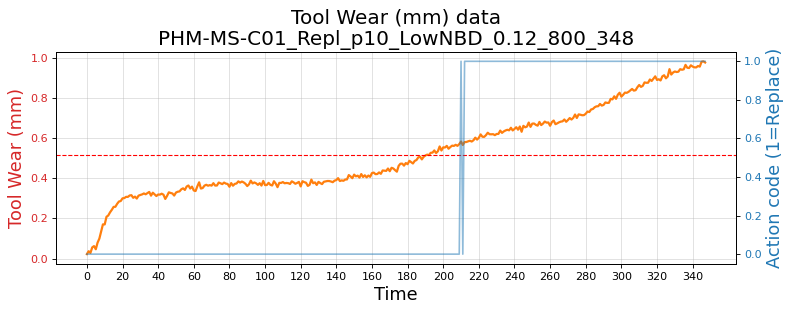

In [444]:
n_records = len(df_train.index)
x = [n for n in range(n_records)]
y1 = df_train['tool_wear']
y2 = df_train['ACTION_CODE']
wear_plot = f'{RESULTS_FOLDER}/{VERSION}_wear_plot.png'
title=f'Tool Wear (mm) data\n{VERSION}'
two_axes_plot(x, y1, y2, title=title, x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=20, file=wear_plot, threshold=WEAR_THRESHOLD_NORMALIZED)

## Milling Tool Environment - 
1. MillingTool_SS: Single state: tool_wear and time
2. MillingTool_MS: Multie-state: force_x; force_y; force_z; vibration_x; vibration_y; vibration_z; acoustic_emission_rms; tool_wear
- Note: ACTION_CODE is only used for evaluation later (testing phase) and is NOT passed as part of the environment states

In [445]:
env = MillingTool_MS_V3(df_train, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE, R1, R2, R3)
env_test = MillingTool_MS_V3(df_test, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE, R1, R2, R3)


# env = MillingTool_MS_V2(df_train, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE, 1.0, -2.0, -100.00)


** -- Multi-variate state V3 env. R1: 1.0, R2: -1.0, R3: 10.0. Noise: 1000.0. Break-down chance: 0.05 -- **


** -- Multi-variate state V3 env. R1: 1.0, R2: -1.0, R3: 10.0. Noise: 1000.0. Break-down chance: 0.05 -- **



## REINFORCE RL Algorithm

In [446]:
### Main loop
rewards_history = []
loss_history = []
training_stats = []

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent_RF = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()

    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent_RF.act(state)
        state, reward, done, info = env.step(action)
        agent_RF.rewards.append(reward)
        #env.render()
        if done:
            # print('** DONE **', info)
            break

    # Learn during this episode 
    loss = agent_RF.learn() # train per episode
    total_reward = sum(agent_RF.rewards)

    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting

    # On-policy - so discard all data 
    agent_RF.onpolicy_reset()

    if (episode%100 == 0):
        # print(f'[{episode:04d}] Loss: {loss:>10.2f} | Reward: {total_reward:>10.2f} | Ep.length: {env.ep_length:04d}')
        print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss:   2.27e+01 | Reward:   3.83e-01 | Ep.length: 0348
[0100] Loss:   2.96e-03 | Reward:   6.07e-01 | Ep.length: 0348
[0200] Loss:   1.02e-03 | Reward:   6.07e-01 | Ep.length: 0348
[0300] Loss:   5.47e-04 | Reward:   6.07e-01 | Ep.length: 0348
[0400] Loss:   3.48e-04 | Reward:   6.07e-01 | Ep.length: 0348
[0500] Loss:   2.24e-04 | Reward:   6.07e-01 | Ep.length: 0348
[0600] Loss:   1.74e-04 | Reward:   6.07e-01 | Ep.length: 0348
[0700] Loss:   1.24e-04 | Reward:   6.07e-01 | Ep.length: 0348


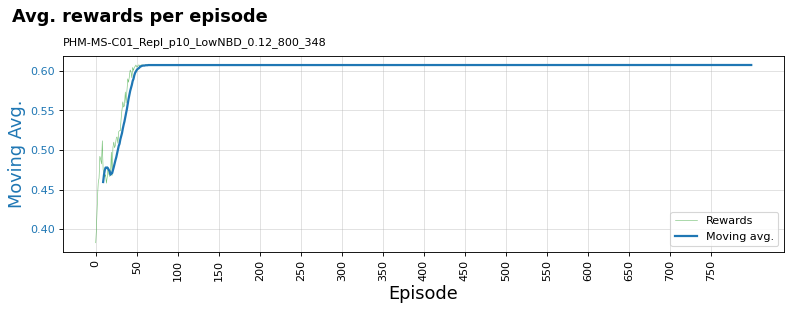

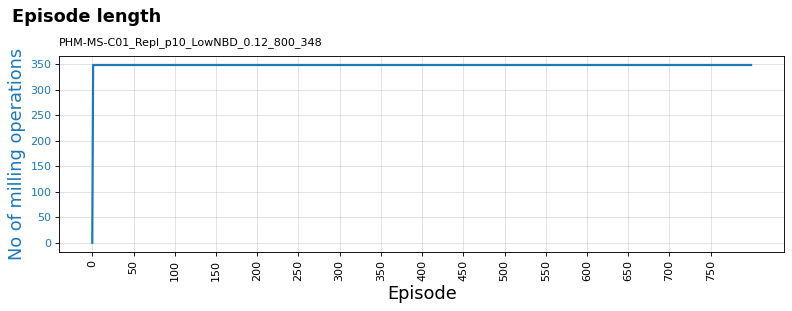

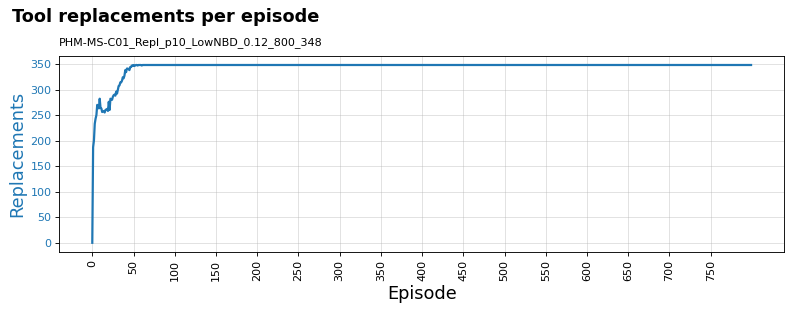

In [447]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = f'{RESULTS_FOLDER}/{VERSION}_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', VERSION, 'Episode', 'Avg. Rewards', 'Moving Avg.', 50, filename)

# plot_error_bounds(x, y1)

filename = f'{RESULTS_FOLDER}/{VERSION}_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', VERSION, 'Episode', 'No of milling operations', 50, 0.0, filename)

filename = f'{RESULTS_FOLDER}/{VERSION}_Tool_Replacements.png' 
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', VERSION, 'Episode', 'Replacements', 50, 0.0, filename)


### Generate a balanced test set

In [448]:
idx_replace_cases = df_test.index[df_test['ACTION_CODE'] >= 1.0]
idx_normal_cases = df_test.index[df_test['ACTION_CODE'] < 1.0]

In [449]:
# Process results
# eps = [i for i in range(EPISODES)]
# store_results(RF_TRAINING_FILE, training_round, eps, rewards_history, env.ep_tool_replaced_history)
print('\n === REINFORCE model trained ===\n')
print(80*'-')
print(f'Algorithm\tNormal\terr.%\tReplace\terr.%\tOverall err.%')
print(80*'-')
for test_round in range(TEST_ROUNDS):
    # Create test cases
    idx_replace_cases = np.random.choice(idx_replace_cases, int(TEST_CASES/2), replace=False)
    idx_normal_cases = np.random.choice(idx_normal_cases, int(TEST_CASES/2), replace=False)
    test_cases = [*idx_normal_cases, *idx_replace_cases]
    
    results = test_script(METRICS_METHOD, test_round, df_test, 'REINFORCE', EPISODES, env_test, ENVIRONMENT_INFO, agent_RF, 
                          test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
    write_test_results(results, RESULTS_FILE)
    
print(f'\n- Test results written to file: {RESULTS_FILE}')


 === REINFORCE model trained ===

--------------------------------------------------------------------------------
Algorithm	Normal	err.%	Replace	err.%	Overall err.%
--------------------------------------------------------------------------------
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500
REINFORCE	20	1.000	20	0.000	0.500

- Test results written to file: results/20-May-2023/PHM-MS-C01_Repl_p10_LowNBD_0.12_800_348_test_results_21-May-2023_2017.csv


## Stable-Baselines Algorithms

In [450]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [451]:
algos = ['A2C','DQN','PPO']

SB_agents = []

for SB_ALGO in algos:
    if SB_ALGO.upper() == 'A2C': agent_SB = A2C('MlpPolicy', env)
    if SB_ALGO.upper() == 'DQN': agent_SB = DQN('MlpPolicy', env)
    if SB_ALGO.upper() == 'PPO': agent_SB = PPO('MlpPolicy', env)
    
    print(f'\n{SB_ALGO} - Training and Testing Stable-Baselines-3 {SB_ALGO} algorithm')
    agent_SB.learn(total_timesteps=EPISODES)

    SB_agents.append(agent_SB)
    print(agent_SB)


A2C - Training and Testing Stable-Baselines-3 A2C algorithm

DQN - Training and Testing Stable-Baselines-3 DQN algorithm

PPO - Training and Testing Stable-Baselines-3 PPO algorithm


In [452]:
n = 0
for agent_SB in SB_agents:
    print(f'\n\n - Testing Stable-Baselines-3 {agent_SB}')
    print(80*'-')
    print(f'Algo.\tNormal\tErr.%\tReplace\tErr.%\tOverall err.%')
    print(80*'-')
    for test_round in range(TEST_ROUNDS):
        # Create test cases
        idx_replace_cases = np.random.choice(idx_replace_cases, int(TEST_CASES/2), replace=False)
        idx_normal_cases = np.random.choice(idx_normal_cases, int(TEST_CASES/2), replace=False)
        test_cases = [*idx_normal_cases, *idx_replace_cases]
        results = test_script(METRICS_METHOD, test_round, df_test, algos[n], EPISODES, env_test, ENVIRONMENT_INFO, 
                              agent_SB, test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
        write_test_results(results, RESULTS_FILE)
    n += 1



 - Testing Stable-Baselines-3 <stable_baselines3.a2c.a2c.A2C object at 0x00000173098179A0>
--------------------------------------------------------------------------------
Algo.	Normal	Err.%	Replace	Err.%	Overall err.%
--------------------------------------------------------------------------------
A2C	20	0.450	20	0.400	0.425
A2C	20	0.650	20	0.300	0.475
A2C	20	0.450	20	0.600	0.525
A2C	20	0.500	20	0.500	0.500
A2C	20	0.450	20	0.400	0.425
A2C	20	0.350	20	0.550	0.450
A2C	20	0.400	20	0.650	0.525
A2C	20	0.500	20	0.550	0.525
A2C	20	0.350	20	0.450	0.400
A2C	20	0.600	20	0.700	0.650


 - Testing Stable-Baselines-3 <stable_baselines3.dqn.dqn.DQN object at 0x0000017314FC3700>
--------------------------------------------------------------------------------
Algo.	Normal	Err.%	Replace	Err.%	Overall err.%
--------------------------------------------------------------------------------
DQN	20	1.000	20	0.000	0.500
DQN	20	0.950	20	0.100	0.525
DQN	20	0.950	20	0.000	0.475
DQN	20	1.000	20	0.000	0.500
DQN	

### Create a consolidated algorithm wise metrics summary

In [453]:
print(80*'-', f'\n Algorithm level consolidated metrics being reported to file:\n {METRICS_FILE}\n', 80*'-')

header_columns = [VERSION]
write_test_results(header_columns, METRICS_FILE)
header_columns = ['Date', 'Time', 'Environment', 'Noise', 'Breakdown_chance', 'Train_data', 'env.R1', 'env.R2', 'env.R3', 'Wear threshold', 'Wear threshold (train)', 'Episodes', 'Terminate on',
                  'Test_info', 'Test_cases', 'Metrics_method']
write_test_results(header_columns, METRICS_FILE)

dt_t = dt.strftime('%H:%M:%S')
noise_info = 'None' if ADD_NOISE == 0 else (1/ADD_NOISE)
header_info = [dt_d, dt_t, ENVIRONMENT_INFO, noise_info, BREAKDOWN_CHANCE, DATA_FILE, env.R1, env.R2, env.R3, WEAR_THRESHOLD, THRESHOLD_FACTOR*WEAR_THRESHOLD, EPISODES, MILLING_OPERATIONS_MAX, TEST_INFO, TEST_CASES, METRICS_METHOD]
write_test_results(header_info, METRICS_FILE)
write_test_results([], METRICS_FILE) # leave a blank line

print('- Experiment related meta info written')

df_algo_results = pd.read_csv(RESULTS_FILE)
# algo_metrics = compute_metrics_simple(df_algo_results)
algo_metrics = compute_metrics(df_algo_results)

write_metrics_report(algo_metrics, METRICS_FILE, 4)
write_test_results([], METRICS_FILE) # leave a blank line
print('- Algorithm level consolidated metrics reported to file')

## ------------------------------------------------------------------------------------------
write_test_results(header_columns, CONSOLIDATED_METRICS_FILE)
write_test_results(header_info, CONSOLIDATED_METRICS_FILE)
write_test_results([], CONSOLIDATED_METRICS_FILE) # leave a blank line
write_metrics_report(algo_metrics, CONSOLIDATED_METRICS_FILE, 4)
write_test_results([120*'-'], CONSOLIDATED_METRICS_FILE) # leave a blank line
print(f'- {CONSOLIDATED_METRICS_FILE} file updated')
print('\n\n ================= END OF PROGRAM =================')

algo_metrics.round(3)

-------------------------------------------------------------------------------- 
 Algorithm level consolidated metrics being reported to file:
 results/20-May-2023/PHM-MS-C01_Repl_p10_LowNBD_0.12_800_348_metrics.csv
 --------------------------------------------------------------------------------
- Experiment related meta info written
- Algorithm level consolidated metrics reported to file
- results/20-May-2023/CONSOLIDATED_METRICS.csv file updated


 ================= END OF PROGRAM =================


Precision        Recall        F_Beta_0_5        F_Beta_0_75         \
               mean    std   mean    std       mean    std        mean    std   
Algorithm                                                                       
A2C           0.508  0.079   0.49  0.124      0.502  0.083       0.498  0.088   
DQN           0.501  0.014   0.98  0.042      0.555  0.016       0.608  0.019   
PPO           0.509  0.081   0.60  0.105      0.524  0.079       0.537  0.080   
REINFORCE     0.500  0.000   1.00  0.000      0.556  0.000       0.610  0.000   

          F_1_Score        Normal_error Replace_error Overall_error  
               mean    std         mean          mean          mean  
Algorithm                                                            
A2C           0.496  0.094        0.470          0.51         0.490  
DQN           0.663  0.021        0.975          0.02         0.497  
PPO           0.549  0.081        0.585          0.40         0.492  
REINFORCE     0.667  0.000        1.000          0.00         0.500

In [454]:
WEAR_THRESHOLD, THRESHOLD_FACTOR*100, THRESHOLD_FACTOR*WEAR_THRESHOLD, ADD_NOISE, BREAKDOWN_CHANCE, EPISODES, MILLING_OPERATIONS_MAX, VERSION

(0.12,
 90.0,
 0.108,
 1000.0,
 0.05,
 800,
 348,
 'PHM-MS-C01_Repl_p10_LowNBD_0.12_800_348')

In [455]:
DATA_FILE

'data\\PHM_Tool_Wear_Data_C01_0p12.csv'

In [456]:
env.R1, env.R2, env.R3 

(1.0, -1.0, 10.0)